In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install statsmodels
!pip install pmdarima
import statsmodels as stat
import pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.9 MB/s eta 0:00:00


## **Data preparation**

In [3]:
path = "/content/XAUUSD.csv"
df = pd.read_csv(path)
df.columns = df.iloc[0]
df = df.drop(index=0)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')
df["Close"] = pd.to_numeric(df["Close"])
df = df[::-1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 622 to 1
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          622 non-null    datetime64[ns]
 1   Open          622 non-null    object        
 2   High          622 non-null    object        
 3   Low           622 non-null    object        
 4   Close         622 non-null    float64       
 5   Change(Pips)  622 non-null    object        
 6   Change(%)     622 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 34.1+ KB


In [4]:
data = df[["Date", "Close"]]
data.set_index("Date", inplace=True)
data.head(5)

,Close
Date,
2021-07-04,1786.39
2021-07-05,1791.15
2021-07-06,1795.68
2021-07-07,1803.22
2021-07-08,1803.75


## **Plot data**
to see if It's stationary or not

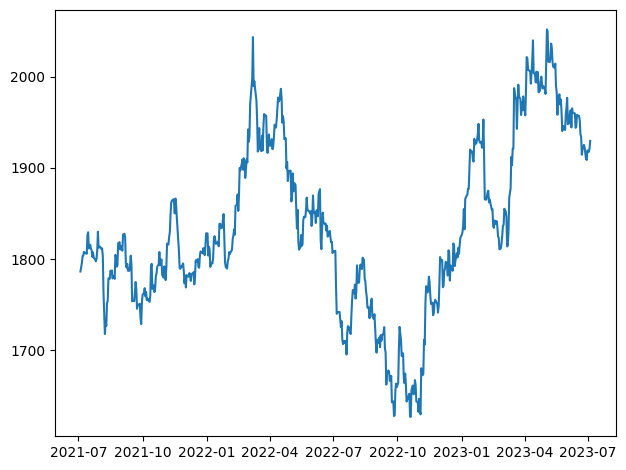

In [5]:
# plt.figure(figsize=(12,8))
# plt.style.use("fivethirtyeight")
plt.plot(data["Close"])
plt.tight_layout()
plt.show()

## **Time series analyse**
There is a two method analyse of time series:
- ***The Additive Model***:
$y(t) = Level + Trend + Seasonality + Noise$

- ***The Multiplicative Model***:
$y(t) = Level * Trend * Seasonality * Noise$

    - **Level**: is the average value in the series.
    - **Trend**: is the increasing or decreasing value in the series.
    - **Seasonality**: is the repeating the short-term cycle in the series.
    - **Noise**: is the random variation in the series.

*decomposition is a process of deconstructing a time series*


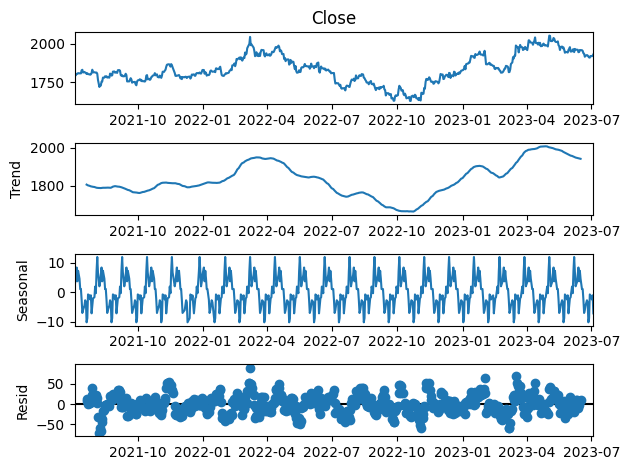

In [6]:
# Check if data is stationary or not?from statsmodels.tsa.seasonal import seasonal_decompose
# use 30 days period for almost every month
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data["Close"], model="additive", period=30)

decomposed.plot()
plt.show()

### **Check if data is stationary or not?**

#### **Dickey-Fuller** test
We must find out data is Stationary or not.
from plot above It's obvious that It's not stationary but for certainty
we use **Dickey-Fuller** test:
- IF P_value is above `0.05` data aren't stationary.
- for more information visit the link below:
    - https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
- for see the code input and output visit link below:
     - https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html

In [7]:
from statsmodels.tsa.stattools import adfuller
_, p_value, _, _, _, _ = adfuller(data["Close"])
print(f"p_value is : {p_value}")

p_value is : 0.35533399855974857


#### **ACF PACF plot**
Auto-Regressive and Moving Average Models:
- *The Auto-Regressive* (AR) model assumes that the current value $y_t$ is dependent on previous values $y_{t-1}, y_{t-2}, …$
    - Because of this assumption, we can build a linear regression model.
- *The Moving Average *(MA) model assumes that the current value $y_t$ is dependent on the error terms including the current error $𝜖_t, 𝜖_{t-1},…$.
    - Because error terms are random, there’s no linear relationship between the current value and the error terms.

The **ACF** and **PACF** are used to figure out the order of AR, MA, and ARMA models.
- you can see a blue area in the ACF and PACF plots. This blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.
    - so if the are to many plot out of the blue area data are random

<img src=https://miro.medium.com/v2/resize:fit:1400/format:webp/1*X7T8Xg1DAqAYf9dcX6n_7A.png>

for more information visit the link below:
- https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


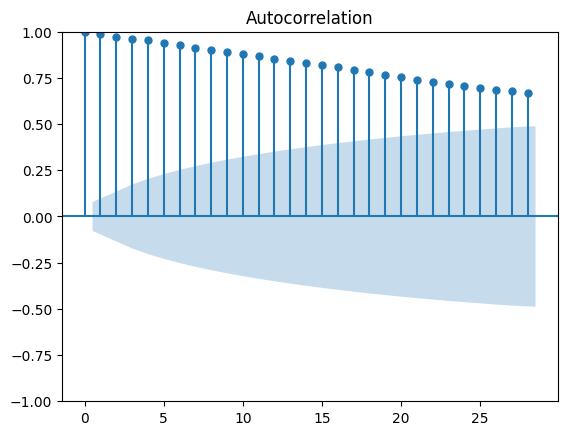

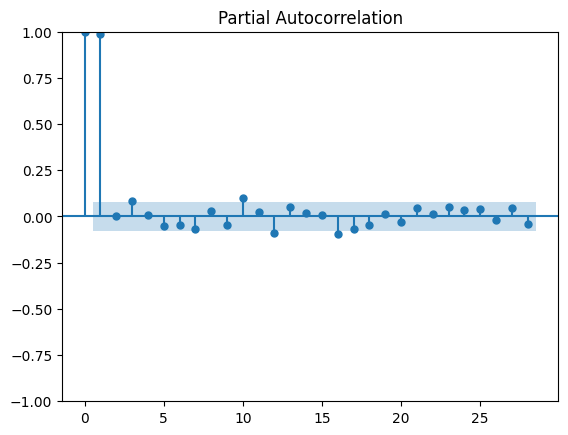

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(data["Close"])
pacf = plot_pacf(data["Close"])

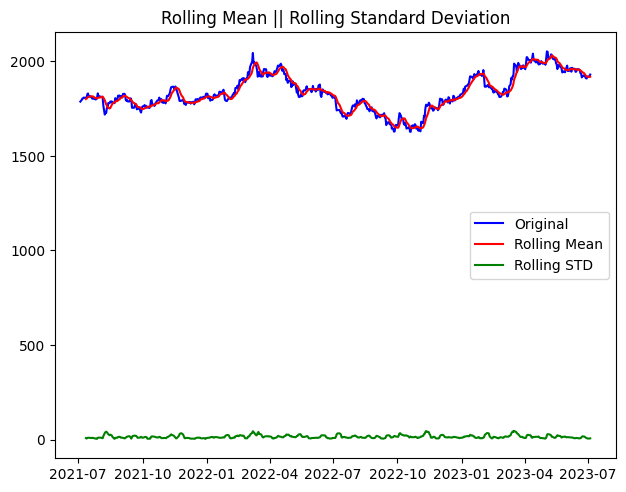

In [9]:
# We want to see the Mean and Std trend, If it's stable the data are stationary
rolling_mean = data.rolling(window = 8).mean()
rolling_std = data.rolling(window = 8).std()

# ploting the data
plt.plot(data["Close"], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.tight_layout()
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

## **Scale data**
scale the data to check the new p_value, to see if we can get the interested p_value

In [10]:
# check P_value in log scale
df_log = np.log(df["Close"])
df_log = pd.concat([df_log, df["Date"]], axis=1)
df_log.set_index("Date", inplace=True)

_, p_value, _, _, _, _ = adfuller(df_log["Close"])
print(f"p_value is : {p_value}")

p_value is : 0.35870031399537977


In [11]:
# define function to do previous method
def get_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller

    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='green', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    result = adfuller(timeseries["Close"])
    print(f'ADF Statistic: {result[0]}')
    print(f'p value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

### **EWMA**
The Exponentially Weighted Moving Average is a quantitative technique used as a forecasting model for time series analysis. The concept of using a moving average is designed to give more weight for newer data points and less for older ones.

$ \mathrm{EWMA} = \alpha  \ast r_t \ast (1 - \alpha) \ast \mathrm{EWMA_{t-1}} $

- Alpha = The weight decided by you
- r = Value of the series in the current period

for more information visit the link below:
 - https://www.isixsigma.com/dictionary/exponentially-weighted-moving-average-ewma/#:~:text=The%20Exponentially%20Weighted%20Moving%20Average,the%20data%20points%20get%20older.

in pandas we have hyperparameter `halflife`:
- $ \Large{\alpha =  \mathrm{e}^{-\frac{{\ln(2)}}{\texttt{halflife}}}}$

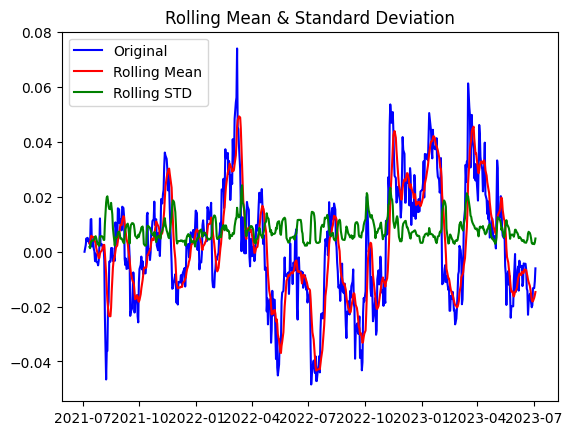

ADF Statistic: -4.587111194537173
p value: 0.000136422780429135
Critical Values:
	1%: -3.440924132966757
	5%: -2.866205413627313
	10%: -2.5692545786625383


In [12]:
# calculate EWMA
rolling_df_ewm= df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

# Scale the data by EWMA
df_ewm= df_log - rolling_df_ewm
df_ewm.dropna(inplace=True)
get_stationarity(df_ewm)

## **Auto correlation**
measure the relationship between a variable’s present value and any past values that you may have access to.

we use pandas built_in function

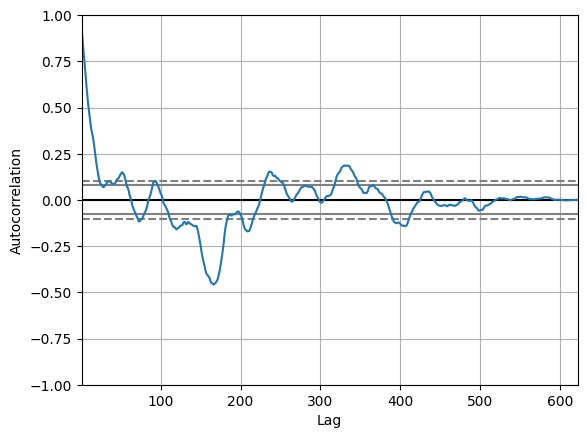

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_ewm["Close"])
plt.show()

# data above dashed line is highley correlated

## **ARIMA**
Autoregressive Integrated Moving Average

- components:
    - **Autoregression (AR**): refers to a model that shows a changing variable that regresses on its own prior, values.
    - **Integrated (I)**: represents the differencing of raw observations
    - **Moving average (MA)**:  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

- Parameters:

    - **p (AR)**: the number of lag observations in the model, also known as the lag order.
    - **d (I)**: the number of times the raw observations are differenced; also known as the degree of differencing.
    - **q (MA)**: the size of the moving average window, also known as the order of the moving average.

### **auto-ARIMA**
- In order to find the best model, ```auto_arima()``` optimizes for a given
- For more information visit the link below:
    - https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [14]:
from pmdarima.arima import auto_arima
# Lower case represent non-seasonal
# Upper case represent seasonal

arima_model = auto_arima(
    df_ewm["Close"],
    start_p=0, d=0, start_q=0,
    max_p=10, max_q=10, max_d=10,
    start_P=0, D=0, start_Q=0,
    max_P=10, max_Q=10, max_D=10,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings= True,
    stepwise=True,
    n_fits=10
)

# arima_model = auto_arima(
#     df_log["Close"],
#     trace=True,
#     suppress_warnings= True,
# )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3028.034, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4304.687, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3600.074, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3024.174, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4302.754, Time=1.54 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4302.767, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4301.206, Time=1.57 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4306.513, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4304.577, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4304.589, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3597.456, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4303.025, Time=0.49 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 6.652 seconds


In [15]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  622
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2155.256
Date:                Tue, 11 Jul 2023   AIC                          -4306.513
Time:                        13:31:15   BIC                          -4297.647
Sample:                             0   HQIC                         -4303.067
                                - 622                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9347      0.012     74.986      0.000       0.910       0.959
sigma2      5.699e-05   2.38e-06     23.961      0.000    5.23e-05    6.17e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                74.67
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Develop model**

### **Create Train/Test data**

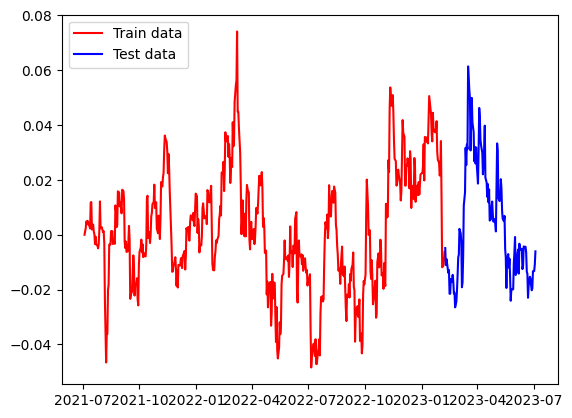

In [16]:
size = int(len(df_log) * 0.8)
end = len(data)
X_train = df_ewm[:size]
X_test = df_ewm[size:]

plt.plot(X_train, color="red", label="Train data")
plt.plot(X_test, color="b", label="Test data")
plt.legend()
plt.show()

### **Create ARIMA model and fit on train data**

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# model = SARIMAX(X_train['Close'],
#                 order = (0, 1, 0),
#                 seasonal_order =(2, 1, 1, 12))

model = ARIMA(X_train,
              order = (1, 0, 0),
              seasonal_order =(2, 1, 1, 12))

result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  497
Model:             ARIMA(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                1651.839
Date:                            Tue, 11 Jul 2023   AIC                          -3293.678
Time:                                    13:31:26   BIC                          -3272.758
Sample:                                         0   HQIC                         -3285.458
                                            - 497                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9139      0.016     58.658      0.000       0.883       0.944
ar.S.L12      -0.0708      0.050   

### **Check prediction for train data and plot them**

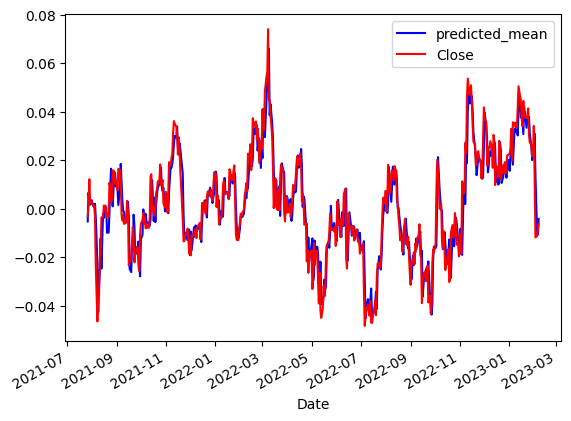

In [18]:
#Train prediction
start_index = 20
train_prediction = result.predict(start_index, size-1)

train_prediction.plot(legend = True, color="b")
X_train['Close'][20:].plot(legend = True, color='red')
plt.show()

### **Check error**

In [19]:
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(X_train[20:], train_prediction))
error

0.008034292131860788

### **Make prediction on test data**

In [20]:
#Prediction
prediction = result.predict(size, end-1).rename('Predicted test')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
train_prediction = pd.DataFrame(train_prediction)
prediction = pd.DataFrame(prediction)
prediction["Date"] = X_test.index
prediction.set_index("Date", inplace=True)

In [22]:
df_train = np.exp(X_train + rolling_df_ewm[:size])
df_train_pred = pd.DataFrame(np.exp(train_prediction["predicted_mean"] + rolling_df_ewm["Close"][20:size]))

df_test = np.exp(X_test + rolling_df_ewm[size:])
df_test_pred = pd.DataFrame(np.exp(prediction['Predicted test'] + rolling_df_ewm["Close"][size:]))

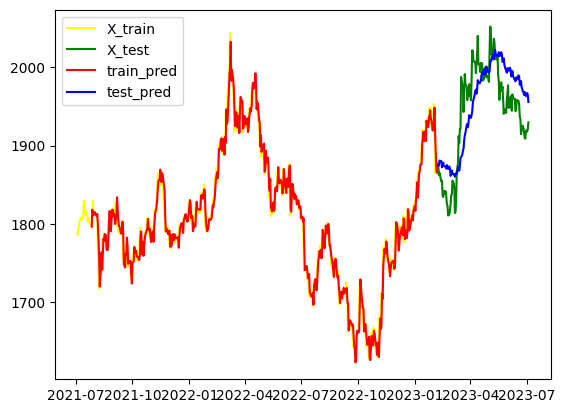

In [23]:
plt.plot(df_train[::-1], label="X_train", color='yellow')
plt.plot(df_test[::-1], label="X_test", color='green')
plt.plot(df_train_pred[::-1], label="train_pred", color='red')
plt.plot(df_test_pred[::-1], label="test_pred", color='b')
plt.legend()
plt.show()

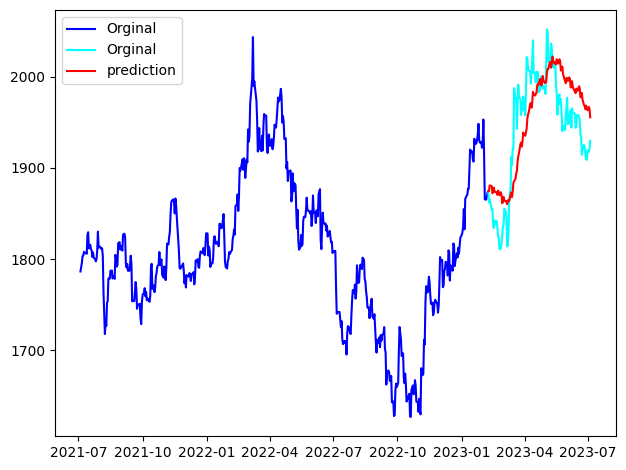

In [24]:
plt.plot(data["Close"][:size], color="blue", label="Orginal")
plt.plot(data["Close"][size:], color="cyan", label="Orginal")
plt.plot(df_test_pred[::-1], label="prediction", color='red')
plt.legend()
plt.tight_layout()
plt.show()